# PT hardcoded filstier, det må lige løses

# Setup

In [21]:
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go


# === CONFIGURATION ===
# === PATHS (relative) ===
csv_path = (r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Modeller\55K - SDU  NyeBilleder\final_results_with_distance.csv")
image_folder = (r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Data\Clean Data\Overbite Data\Annotated Verification Data Pairs")
output_csv_path = (r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Pixel_matrix.csv")


# === LOAD CSV ===
df = pd.read_csv(csv_path)

# Prepare a list to store new refined points
refined_data = []

# === UTILITY FUNCTION ===
def refine_guess_with_pixel_matrix(image, x_center, y_center, window_size=15):
    half_size = window_size // 2
    x_min = int(max(x_center - half_size, 0))
    x_max = int(min(x_center + half_size + 1, image.shape[1]))
    y_min = int(max(y_center - half_size, 0))
    y_max = int(min(y_center + half_size + 1, image.shape[0]))

    sub_img = image[y_min:y_max, x_min:x_max]
    
    # Convert to grayscale for intensity checks
    gray = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
    
    # Find non-black pixels
    non_black_pixels = np.argwhere(gray > 0)
    if len(non_black_pixels) == 0:
        return x_center, y_center  # fallback: no adjustment

    # Find topmost (lowest y) non-black pixel(s)
    top_y = np.min(non_black_pixels[:, 0])
    top_pixels = non_black_pixels[non_black_pixels[:, 0] == top_y]
    
    # Among those, find the brightest
    brightness = [gray[pt[0], pt[1]] for pt in top_pixels]
    brightest_idx = np.argmax(brightness)
    top_pixel = top_pixels[brightest_idx]

    # Convert local (within sub-image) back to global coordinates
    refined_x = x_min + top_pixel[1]
    refined_y = y_min + top_pixel[0]
    return refined_x, refined_y

# === MAIN LOOP ===
for idx, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['Filename'] + ".png"
    img_path = os.path.join(image_folder, filename)
    if not os.path.exists(img_path):
        print(f"Missing: {filename}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read: {filename}")
        continue

    x_model = int(row['X_Model'])
    y_model = int(row['Y_Model'])

    x_refined, y_refined = refine_guess_with_pixel_matrix(image, x_model, y_model)


    # Load image
    im = cv2.imread(img_path)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    height, width = im.shape[:2]

    # Set keypoints
    x_true, y_true = row['X_True'], row['Y_True']
    x_model, y_model = int(row['X_Model']), int(row['Y_Model'])
    x_refined, y_refined = int(x_refined), int(y_refined)

    # === Start Plotly Figure ===
    fig = go.Figure()

    # --- Background Image ---
    fig.add_trace(go.Image(z=im_rgb, name="Image"))

    # --- True Keypoint (Green) ---
    fig.add_trace(go.Scatter(
        x=[x_true], y=[y_true],
        mode='markers+text',
        name="True Keypoint",
        text=["True"],
        textposition="top right",
        marker=dict(color='green', size=5),
        showlegend=True
    ))

    # --- Model Guess Keypoint (Red) ---
    fig.add_trace(go.Scatter(
        x=[x_model], y=[y_model],
        mode='markers+text',
        name="Model Guess",
        text=["Model"],
        textposition="top right",
        marker=dict(color='red', size=5),
        showlegend=True
    ))

    # --- Refined Keypoint (Blue) ---
    fig.add_trace(go.Scatter(
        x=[x_refined], y=[y_refined],
        mode='markers+text',
        name="Refined Keypoint",
        text=["Refined"],
        textposition="top right",
        marker=dict(color='blue', size=5),
        showlegend=True
    ))

    # --- 15x15 Pixel Search Window (Yellow BBox) ---
    half_size = 15 // 2
    bbox_x0 = x_model - half_size
    bbox_y0 = y_model - half_size
    bbox_x1 = x_model + half_size
    bbox_y1 = y_model + half_size

    # Define bounding box as line loop
    fig.add_trace(go.Scatter(
        x=[bbox_x0, bbox_x1, bbox_x1, bbox_x0, bbox_x0],
        y=[bbox_y0, bbox_y0, bbox_y1, bbox_y1, bbox_y0],
        mode='lines',
        name="15x15 Window",
        line=dict(color='yellow', dash='dash', width=1),
        showlegend=True
    ))

    # === Layout ===
    fig.update_layout(
        title=f"Pixel Matrix Refinement: {row['Filename']}",
        xaxis=dict(visible=False, range=[0, width], scaleanchor="y", constrain="domain"),
        yaxis=dict(visible=False, range=[height, 0], scaleanchor="x", constrain="domain"),
        showlegend=True,
        height=height,
        width=width,
        margin=dict(l=0, r=0, t=40, b=0),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    #fig.show(renderer="browser")
    # Create output folder if needed
    output_html_dir = (r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Image Output")
    os.makedirs(output_html_dir, exist_ok=True)

    # Save to HTML
    html_path = os.path.join(output_html_dir, f"{row['Filename']}.html")
    fig.write_html(html_path)


    # === Append Data ===
    refined_data.append({
        'Filename': row['Filename'],
        'X_Model': x_model,
        'Y_Model': y_model,
        'X_Refined': x_refined,
        'Y_Refined': y_refined,
        'X_True': row['X_True'],
        'Y_True': row['Y_True']
    })


# === SAVE OUTPUT ===
refined_df = pd.DataFrame(refined_data)
refined_df.to_csv(output_csv_path, index=False)
print(f"Saved refined results to {output_csv_path}")


100%|██████████| 400/400 [00:39<00:00, 10.25it/s]

Saved refined results to C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Pixel_matrix.csv


# Udregn afstande

In [1]:
import pandas as pd
import numpy as np
import os

# === CONFIG ===
csv_path = r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Pixel_matrix.csv"
output_path = r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Pixel_matrix_with_distances.csv"

# Pixel to mm scale
PIXEL_TO_MM = 0.08

# === Load CSV ===
df = pd.read_csv(csv_path)

# === Calculate Distances ===
dx = df['X_Refined'] - df['X_True']
dy = df['Y_Refined'] - df['Y_True']
df['Refined_Pixel_Dist'] = np.sqrt(dx**2 + dy**2)
df['Refined_mm_Dist'] = df['Refined_Pixel_Dist'] * PIXEL_TO_MM

# === Save New CSV ===
df.to_csv(output_path, index=False)
print(f"✅ Distance-calculated CSV saved to:\n{output_path}")


✅ Distance-calculated CSV saved to:
C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Pixel_matrix_with_distances.csv


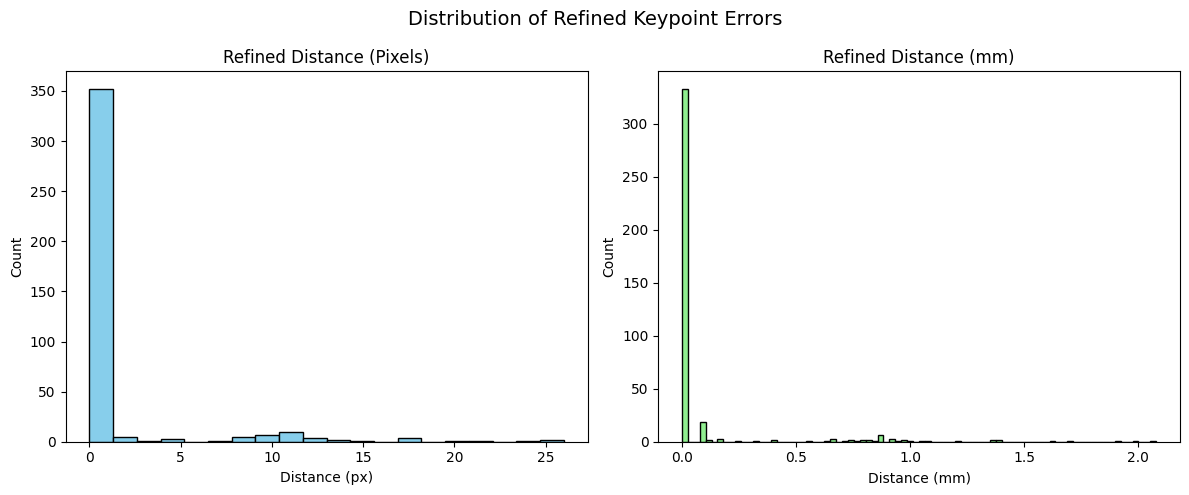

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# === Load refined CSV with distances ===
df = pd.read_csv(r"C:\STUDIE\4. Semester\Dataprojekt\Dataprojekt\Overbite_Overjet\Pixel matrix\Pixel_matrix_with_distances.csv")

# === Plot histogram ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Pixel Distance Histogram
ax[0].hist(df['Refined_Pixel_Dist'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title("Refined Distance (Pixels)")
ax[0].set_xlabel("Distance (px)")
ax[0].set_ylabel("Count")

# --- Millimeter Distance Histogram
ax[1].hist(df['Refined_mm_Dist'], bins=80, color='lightgreen', edgecolor='black')
ax[1].set_title("Refined Distance (mm)")
ax[1].set_xlabel("Distance (mm)")
ax[1].set_ylabel("Count")

plt.suptitle("Distribution of Refined Keypoint Errors", fontsize=14)
plt.tight_layout()
plt.show()
